# Importing dataset and libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sb

In [2]:
#Reading dataset
stock_prices_twitter = pd.read_csv("tables/stocks_data_twitter.csv", parse_dates=['date'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Trying K-means clustering

In [3]:
#choosing the variables to do clustering
Database_1 = stock_prices_twitter[["mean_overall_sentiment", 
                               "mean_positive_sentiment",
                                "mean_negative_sentiment", "mean_negative_neutral_sentiment","company_name"]].groupby("company_name").agg("mean")

Database_1 = Database_1.reset_index()
Database_1 = Database_1.drop(columns = ["company_name"])

In [4]:
#getting company and industry names
company_names = stock_prices_twitter[["company_name"]].groupby("company_name").agg("last")
company_names = company_names.reset_index()
industry_names = stock_prices_twitter[["company_name", "industry_name"]].groupby("company_name").agg("last")
industry_names = industry_names.reset_index()

In [5]:
#standardizing the data
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(Database_1)

In [6]:
# using standardized data for clusters
kmeans = KMeans(n_clusters=4) 
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
# Using Elbow method to find right number of clusters
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x)
    kmeanModel.fit(x)
    inertia.append(kmeanModel.inertia_)

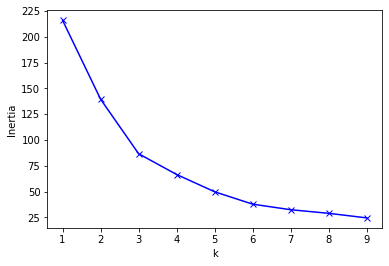

In [8]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [9]:
#fitting with 4 clusters
kmeans = KMeans(n_clusters=4) 

y_kmeans = kmeans.fit(x)

In [10]:
#Adding labels to dataset
labels_kmeans = pd.DataFrame(kmeans.labels_) 
#This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
FinalDataset = pd.concat([Database_1,labels_kmeans],axis=1)
#FinalDataset["labels_kmeans"] = 
FinalDataset = FinalDataset.rename({0:'labels_kmeans'},axis=1)

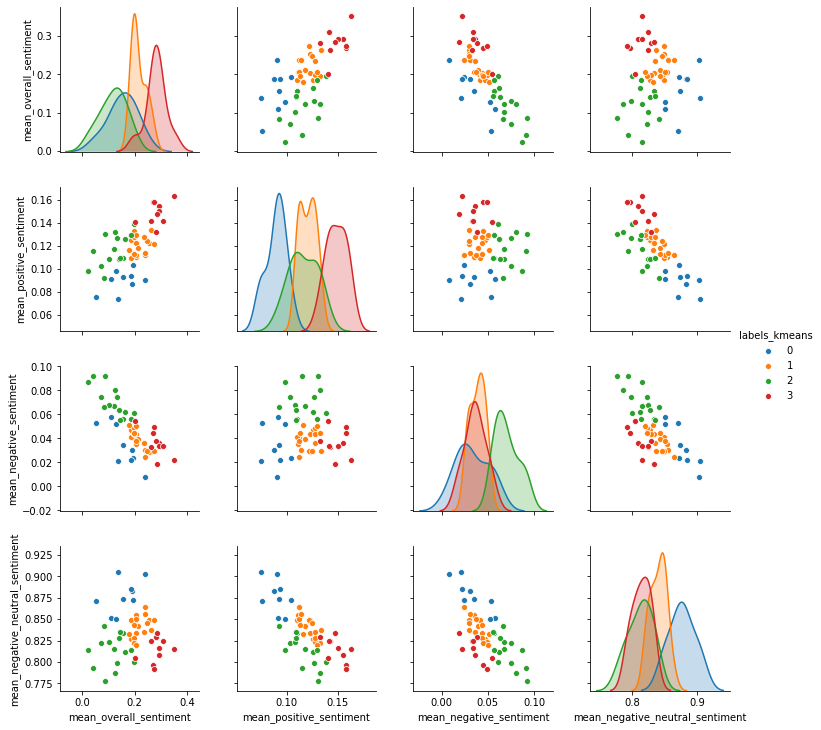

In [11]:
#Plotting the clusters
sns.pairplot(FinalDataset,hue='labels_kmeans')

In [14]:
# Looking at different statistics
FinalDataset.groupby("labels_kmeans").agg(["mean", "count"])

mean_overall_sentiment       mean_positive_sentiment        \
                                mean count                    mean count   
labels_kmeans                                                              
0                           0.154195     9                0.089651     9   
1                           0.216070    20                0.120747    20   
2                           0.117676    15                0.116472    15   
3                           0.281703    10                0.148976    10   

              mean_negative_sentiment       mean_negative_neutral_sentiment  \
                                 mean count                            mean   
labels_kmeans                                                                 
0                            0.033570     9                        0.876771   
1                            0.038771    20                        0.840480   
2                            0.070472    15                        0.813053   
3                            0.036463    10                        0.814559   

                     
              count  
labels_kmeans        
0                 9  
1                20  
2                15  
3                10

In [13]:
# Adding comapny and industry namy
FinalDataset["company_name"] = company_names

FinalDataset["industry_name"] = industry_names["industry_name"]

In [ ]:
FinalDataset[["labels_kmeans", "company_name", "industry_name"]].groupby("company_name").agg("last")

In [ ]:
# Adding column to stock prices dataset
stock_prices_twitter = stock_prices_twitter.merge(FinalDataset[["company_name", "labels_kmeans"]], \
                                                  on = 'company_name', how='left')

Clustering groups are very different from industries. 

# Modeling

## 0. Importing libraries

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import GradientBoostingClassifier


## 1. Adding Lag variables

In [ ]:
#Adding lag to the changes in price
#1 day lag
stock_prices_twitter['change_lag1'] = 100 * (stock_prices_twitter['close'].shift(-1) - stock_prices_twitter['close']) / stock_prices_twitter['close']
stock_prices_twitter.loc[stock_prices_twitter['company_id'] != stock_prices_twitter['company_id'].shift(-1), 
                         'change_lag1'] = np.nan
#2 days lag
stock_prices_twitter['change_lag2'] = 100 * (stock_prices_twitter['close'].shift(-2) - stock_prices_twitter['close']) / stock_prices_twitter['close']
stock_prices_twitter.loc[stock_prices_twitter['company_id'] != stock_prices_twitter['company_id'].shift(-2), 
                         'change_lag2'] = np.nan
#3 days lag
stock_prices_twitter['change_lag3'] = 100 * (stock_prices_twitter['close'].shift(-3) - stock_prices_twitter['close']) / stock_prices_twitter['close']
stock_prices_twitter.loc[stock_prices_twitter['company_id'] != stock_prices_twitter['company_id'].shift(-3), 
                         'change_lag3'] = np.nan

#4 days lag
stock_prices_twitter['change_lag4'] = 100 * (stock_prices_twitter['close'].shift(-4) - stock_prices_twitter['close']) / stock_prices_twitter['close']
stock_prices_twitter.loc[stock_prices_twitter['company_id'] != stock_prices_twitter['company_id'].shift(-4), 
                         'change_lag3'] = np.nan
#7 days lag
stock_prices_twitter['change_lag7'] = 100 * (stock_prices_twitter['close'].shift(-7) - stock_prices_twitter['close']) / stock_prices_twitter['close']
stock_prices_twitter.loc[stock_prices_twitter['company_id'] != stock_prices_twitter['company_id'].shift(-7), 
                         'change_lag3'] = np.nan
#10 days lag
stock_prices_twitter['change_lag10'] = 100 * (stock_prices_twitter['close'].shift(-10) - stock_prices_twitter['close']) / stock_prices_twitter['close']
stock_prices_twitter.loc[stock_prices_twitter['company_id'] != stock_prices_twitter['company_id'].shift(-10), 
                         'change_lag3'] = np.nan

#14 days lag
stock_prices_twitter['change_lag14'] = 100 * (stock_prices_twitter['close'].shift(-14) - stock_prices_twitter['close']) / stock_prices_twitter['close']
stock_prices_twitter.loc[stock_prices_twitter['company_id'] != stock_prices_twitter['company_id'].shift(-14), 
                         'change_lag3'] = np.nan


In [ ]:
stock_prices_twitter["company_name"][stock_prices_twitter["mean_overall_sentiment"] == 0.0000].unique()

## 2. Functions


### 2.1. Preparing the dataset

In [ ]:
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Using most relevant features first - mean overall score, industry_name, number of retweets, number of favorites, week and month 
# removing location and district to eliminate not available data for lags
stock_prices_twitter_2 = stock_prices_twitter[["favories", "month", "labels_kmeans","industry_id","company_name","industry_name", "mean_overall_sentiment", "retweets", "week", "change_lag1", "change_lag2", "change_lag3", "change_lag4", "change_lag7", "change_lag10", "change_lag14"]]
stock_prices_twitter_2 = stock_prices_twitter_2.dropna()

# Function to select features
def selecting_variables(dataset):
    features = dataset[["industry_name", "mean_overall_sentiment", "retweets", "favories", "week",  "month"]]
    features = pd.get_dummies(features)
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)    
    return features
    
    
# Function to scale data
def scaling_data(train_features, test_features):
    scaler = StandardScaler()
    scaler.fit(train_features)
    StandardScaler(copy=True, with_mean=True, with_std=True)
    train_features = scaler.transform(train_features)
    test_features = scaler.transform(test_features)
    return train_features, test_features

# Function to create the labels
def creating_labels(labels):
    labels_class = []
    for i in labels:
        if i >=0:
            labels_class.append("positive")
        if i <0:
            labels_class.append("negative")
    return labels_class

### 2.2. Fitting the models

In [ ]:
def fit_models(train_features, test_features):
    
    #random forest
    rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
    rf.fit(train_features, train_labels)
    
    #NN
    mlp = MLPClassifier(max_iter=50)
    parameter_space = {
        'hidden_layer_sizes': [(15,15,15),(25,25,25), (50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],}


    NN = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
    NN.fit(train_features, train_labels)    
    
    #booster
    booster = GradientBoostingClassifier(n_estimators = 500, random_state = 42)
    booster.fit(train_features, train_labels)
    
    #baseline
    baseline_model_1 = LogisticRegression().fit(train_features, train_labels) 
    
    
    #training predictions - random forest
    train_rf_predictions = rf.predict(train_features)
    train_rf_probs = rf.predict_proba(train_features)[:, 1]  
    
    #testing predictions - random forest
    rf_predictions = rf.predict(test_features)
    rf_probs = rf.predict_proba(test_features)[:, 1] 

    
    #training predictions - NN
    train_NN_predictions = NN.predict(train_features)
    train_NN_probs =  NN.predict_proba(train_features)[:, 1]

    #testing predictions - NN    
    NN_predictions = NN.predict(test_features)
    NN_probs = NN.predict_proba(test_features)[:, 1]

        
    #training predictions - Booster
    train_booster_predictions = booster.predict(train_features)
    train_booster_probs =  booster.predict_proba(train_features)[:, 1]

    #testing predictions - Booster    
    booster_predictions = booster.predict(test_features)
    booster_probs = booster.predict_proba(test_features)[:, 1]
    
    
  
    #testing predictions - baseline
    baseline_predictions = baseline_model_1.predict(test_features)
    baseline_probs = baseline_model_1.predict_proba(test_features)[:, 1] 

    
    
    return train_booster_predictions, train_booster_probs, booster_predictions, booster_probs,baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs 

### 2.3 Evaluating the model

In [ ]:
def evaluate_model(baseline_predictions, baseline_probs,predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}    
    
    #update with correct values
    baseline['recall'] = recall_score(test_labels, baseline_predictions,  pos_label='positive')
    baseline['precision'] = precision_score(test_labels, baseline_predictions,  pos_label='positive')
    baseline['roc'] = roc_auc_score(test_labels, baseline_probs)
    baseline['F1'] = f1_score(test_labels, baseline_predictions, pos_label="positive")
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions,  pos_label='positive')
    results['precision'] = precision_score(test_labels, predictions,  pos_label='positive')
    results['roc'] = roc_auc_score(test_labels, probs)
    results["F1"] = f1_score(test_labels, predictions, pos_label='positive', average='binary')
    
    train_results = {}
    
    train_results['recall'] = recall_score(train_labels, train_predictions,  pos_label='positive')
    train_results['precision'] = precision_score(train_labels, train_predictions,  pos_label='positive')
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    train_results['F1'] = f1_score(train_labels, train_predictions, pos_label='positive', average="binary")
    
    for metric in ['recall', 'precision', 'roc', "F1"]:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, baseline_probs,  pos_label='positive')
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs,  pos_label='positive')

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)




### 2.4 Thresholds Trade-off

In [ ]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    #print(pd.DataFrame(confusion_matrix(train_labels, y_pred_adj),
                       #columns=['pred_neg', 'pred_pos'], 
                       #index=['neg', 'pos']))
    #recall_score(test_labels, predictions,  pos_label='positive')
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')    
    
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')    

## 3. Modelling overall

#### 3.1. Selecting the features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_2)
#Labels:
labels = np.array(stock_prices_twitter_2["change_lag14"])

#### 3.2. Running functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


#### 3.3 Comparing Precision/ Recall Thresholds

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, rf_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.66)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, rf_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.66)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Negative', 'Positive'],
                      title = 'Confusion Matrix')

plt.savefig('cm.png')
 

### 4 Modeling for Industry 1

In [ ]:
#Filtering for industry 1
stock_prices_twitter_industry_1 = stock_prices_twitter_2[stock_prices_twitter_2["industry_id"] == 1]

#### 4.1. Selecting features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_industry_1)
#Labels:
labels = np.array(stock_prices_twitter_industry_1["change_lag10"])

#### 4.2. Running functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


#### 4.3 Comparing Precision/ Recall Thresholds

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, booster_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.66)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

### 5. Modeling for industry 1 with only top companies

#### 5.1 Industry 1 - Top companies

In [ ]:
#Selecting the companies to use
company_names = ["Alphabet Inc", "Amazon.com", "Apple Inc.", "Microsoft Corporation"]

#Filtering
stock_prices_twitter_industry_1_2 = stock_prices_twitter_industry_1[stock_prices_twitter_industry_1["company_name"].isin(company_names)]


#### 5.2 Selecting features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_industry_1_2)
#Labels:
labels = np.array(stock_prices_twitter_industry_1_2["change_lag14"])

#### 5.3 Running functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')

#### 5.4 Comparing Precision/ Recall Thresholds


In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, booster_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.82)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

### 6. Modeling for sector 1 with just Amazon

#### 6.1 Industry 1 - Amazon

In [ ]:
company_names = ["Amazon.com"]
stock_prices_twitter_amazon = stock_prices_twitter_industry_1[stock_prices_twitter_industry_1["company_name"].isin(company_names)]


#### 6.2. Selecting features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_amazon)
#Labels:
labels = np.array(stock_prices_twitter_amazon["change_lag14"])

#### 6.3 Running functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')

#### 6.3 Comparing Precision/ Recall Thresholds


In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, booster_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.9)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

### 7. Modeling for sector 7

In [ ]:
stock_prices_twitter_industry_7 = stock_prices_twitter_2[stock_prices_twitter_2["industry_id"] == 7]

#### 7.1 Selecting features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_industry_7)
#Labels:
labels = np.array(stock_prices_twitter_industry_7["change_lag14"])

#### 7.2 Running functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')

#### 7.3 Comparing Precision/ Recall Thresholds

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, rf_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.9)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

### 8. Modeling for clusters

### 8.1 Cluster 0

In [ ]:
stock_prices_twitter_cluster1 = stock_prices_twitter_2[stock_prices_twitter_2["labels_kmeans"] ==0]

#### 8.1.1 Selecting features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_cluster1)
#Labels:
labels = np.array(stock_prices_twitter_cluster1["change_lag14"])

#### 8.1.2 Run functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')

#### 8.1.3 Comparing Precision/ Recall Thresholds

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, rf_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.9)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

### 8.2 Cluster 1

In [ ]:
stock_prices_twitter_cluster_2 = stock_prices_twitter_2[stock_prices_twitter_2["labels_kmeans"] == 1]

#### 8.2.2 Selecting features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_cluster_2)
#Labels:
labels = np.array(stock_prices_twitter_cluster_2["change_lag14"])

#### 8.2.2 Running functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')

#### 8.2.3 Comparing Precision/ Recall Thresholds

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, rf_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.9)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

### 8.3 Cluster 3

In [ ]:
stock_prices_twitter_cluster_3 = stock_prices_twitter_2[stock_prices_twitter_2["labels_kmeans"] == 2]

#### 8.3.1 Selecting features

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_cluster_3)
#Labels:
labels = np.array(stock_prices_twitter_cluster_3["change_lag14"])

#### 8.3.2 Running functions

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')

#### 8.3.3 Comparing Precision/ Recall Thresholds

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, rf_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.9)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')

### 8.4 Cluster 4

In [ ]:
stock_prices_twitter_cluster_4 = stock_prices_twitter_2[stock_prices_twitter_2["labels_kmeans"] == 3]

#### 8.4.1 Selecting features 

In [ ]:
#Features:
features = selecting_variables(stock_prices_twitter_cluster_4)
#Labels:
labels = np.array(stock_prices_twitter_cluster_4["change_lag14"])

#### 8.4.2 Running model

In [ ]:
#train_features, test_features = scaling_data(train_features, test_features)
labels_class = creating_labels(labels)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_class, test_size = 0.25, random_state = 6240)  
train_booster_predictions, train_booster_probs, booster_predictions, booster_probs, baseline_predictions, baseline_probs, train_rf_predictions, train_rf_probs, rf_predictions, rf_probs, train_NN_predictions, train_NN_probs, NN_predictions, NN_probs = fit_models(train_features, test_features)

evaluate_model(baseline_predictions, baseline_probs, rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs,NN_predictions, NN_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')


evaluate_model(baseline_predictions, baseline_probs, booster_predictions, booster_probs, train_NN_predictions, train_NN_probs)
plt.savefig('roc_auc_curve.png')

#### 8.4.3 Comparing Precision/ Recall Thresholds

In [ ]:
p, r, thresholds = precision_recall_curve(test_labels, rf_probs,  pos_label='positive')
precision_recall_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, 0.9)
plot_precision_recall_vs_threshold  
fpr, tpr, auc_thresholds = roc_curve(test_labels, rf_probs, pos_label = "positive")
plot_roc_curve(fpr, tpr, 'recall_optimized')